In [1]:
!pip3 install -r requirements.txt

In [2]:
#!python3 -m venv myenv

In [3]:
!python3 -m ipykernel install --user --name=myenv
!python3 -m ipykernel install --name=myenv

Installed kernelspec myenv in C:\Users\ismai\AppData\Roaming\jupyter\kernels\myenv


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Installed kernelspec myenv in C:\ProgramData\jupyter\kernels\myenv


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [4]:
#!myenv\Scripts\activate

In [5]:
import numpy as np
import cv2 as cv
import os
import platform
import splitfolders
import matplotlib.pyplot as plt

import tensorflow.keras as keras
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from pathlib import Path

In [6]:
ROOT_DIR = os.path.abspath(os.curdir)
print(ROOT_DIR)

c:\AI-Project


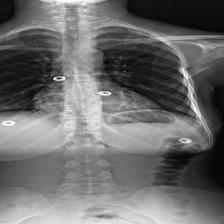

In [7]:
img_normal_path = os.path.join(ROOT_DIR, "data-split/test/Normal/", "N5,N,F,31_1_0.jpg")
img_normal = image.load_img(img_normal_path)
img_normal

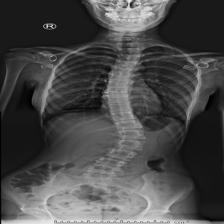

In [8]:
img_scol_path = os.path.join(ROOT_DIR, "data-split/test/Scol/", "N22, Lt TL AIS, F, 14 yrs.jpg")
img_scol = image.load_img(img_scol_path)
img_scol

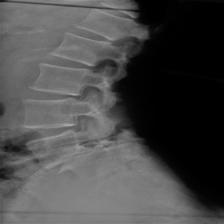

In [9]:
img_spond_path = os.path.join(ROOT_DIR, "data-split/test/Spond/", "N29, Olisthesis L4-5, F, 53 Yrs.jpg")
img_spond = image.load_img(img_spond_path)
img_spond

In [10]:
# split data in a new folder named data-split
datasets_dir = os.path.join(ROOT_DIR, "datasets/224")
datasplit_dir = os.path.join(ROOT_DIR, "data-split")
splitfolders.ratio(datasets_dir, output=datasplit_dir, seed=1337, ratio=(0.7, 0.2, 0.1), group_prefix=None, move=False)

In [11]:
datagen = ImageDataGenerator()

In [12]:
# define classes name
class_names = ['Normal','Scol','Spond']

In [13]:
# training data
train_generator = datagen.flow_from_directory( 
    directory=os.path.join(datasplit_dir, "train"), 
    classes = class_names,
    target_size=(224, 224),  
    batch_size=32, 
    class_mode="binary", 
)

Found 235 images belonging to 3 classes.


In [14]:
# validation data
valid_generator = datagen.flow_from_directory( 
    directory=os.path.join(datasplit_dir, "val"), 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="binary", 
)

Found 66 images belonging to 3 classes.


In [15]:
# test data
test_generator = datagen.flow_from_directory( 
    directory=os.path.join(datasplit_dir, "test"), 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="binary", 
)

Found 37 images belonging to 3 classes.


In [16]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

In [17]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

In [18]:
# define training function
def trainModel(model, epochs, optimizer):
    batch_size = 48
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)

In [19]:
# launch the training
model_history = trainModel(model = model, epochs = 22, optimizer = "Adam")


Epoch 1/22


8/8 [==============================] - 20s 2s/step - loss: 2.5909 - accuracy: 0.3021 - val_loss: 1.0001 - val_accuracy: 0.5606
Epoch 2/22
8/8 [==============================] - 14s 2s/step - loss: 2.0873 - accuracy: 0.4000 - val_loss: 0.9201 - val_accuracy: 0.5606
Epoch 3/22
8/8 [==============================] - 15s 2s/step - loss: 1.5373 - accuracy: 0.4979 - val_loss: 0.8518 - val_accuracy: 0.7576
Epoch 4/22
8/8 [==============================] - 19s 3s/step - loss: 1.5295 - accuracy: 0.4681 - val_loss: 0.9029 - val_accuracy: 0.7576
Epoch 5/22
8/8 [==============================] - 14s 2s/step - loss: 1.1468 - accuracy: 0.5574 - val_loss: 0.8603 - val_accuracy: 0.7121
Epoch 6/22
8/8 [==============================] - 15s 2s/step - loss: 1.1663 - accuracy: 0.5362 - val_loss: 0.8194 - val_accuracy: 0.7273
Epoch 7/22
8/8 [==============================] - 14s 2s/step - loss: 1.0483 - accuracy: 0.5404 - val_loss: 0.7264 - val_accuracy: 0.8030
Epoch 8/22
8/8 [===============

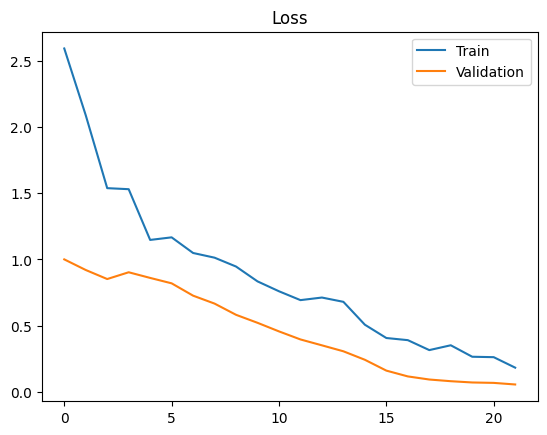

In [20]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

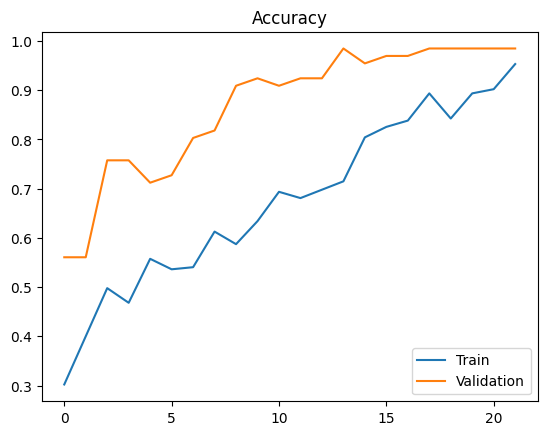

In [21]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

2/2 [==============================] - 2s 305ms/step - loss: 0.3283 - accuracy: 0.8919
The test loss is:  0.32831457257270813
The best accuracy is:  89.18918967247009


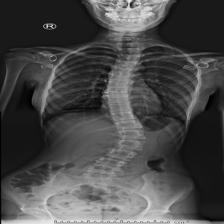

In [34]:
img = tf.keras.preprocessing.image.load_img(img_scol_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img

In [35]:
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 0s 126ms/step
[[4.8957997e-07 9.9999940e-01 2.4965944e-08 5.5801702e-10 2.9905241e-08]]


In [36]:
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

[1]


In [37]:
# transform classes number into classes name
class_names[class_id.item()]

'Scol'

In [27]:
model_path = os.path.join(ROOT_DIR, "model\\", "saved_model")
print(model_path)

c:\AI-Project\model\saved_model


In [28]:
model.save(model_path)

INFO:tensorflow:Assets written to: c:\AI-Project\model\saved_model\assets


INFO:tensorflow:Assets written to: c:\AI-Project\model\saved_model\assets


In [29]:
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          